This is my attempt to understand classical machine learning algorithm which will eventually help me dive deep into the world of Deep Learning. I will be reading this book, "Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow", this August. Starting from first chapter, I will be writing down and understanding the code given in the book which is also available at https://github.com/ageron/handson-ml3/?tab=readme-ov-file.<br>

This is chapter 2 where the author has gone through the complete process of how to build a machine learning project from scratch to production.

# Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import urllib.request
import tarfile

# Loading Data

In [2]:
def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if tarball_path.is_file() == False:
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path = 'datasets')
    return pd.read_csv(Path('datasets/housing/housing.csv'))

In [3]:
housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Create a Test Set

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
housing['income_cat'] = pd.cut(housing['median_income'], bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf], labels = [1,2,3,4,5])

In [7]:
train_set, test_set = train_test_split(housing, test_size=0.20, random_state=42)

In [8]:
splitter = StratifiedShuffleSplit(n_splits= 10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [9]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [10]:
for set in (strat_train_set, strat_test_set):
    set.drop('income_cat', axis = 1, inplace = True)

In [11]:
housing = strat_train_set.copy()

# Visualizing Data

In [12]:
housing.corr(numeric_only=True)['median_house_value']

longitude            -0.050859
latitude             -0.139584
housing_median_age    0.102175
total_rooms           0.137455
total_bedrooms        0.054635
population           -0.020153
households            0.071426
median_income         0.688380
median_house_value    1.000000
Name: median_house_value, dtype: float64

<Axes: xlabel='longitude', ylabel='latitude'>

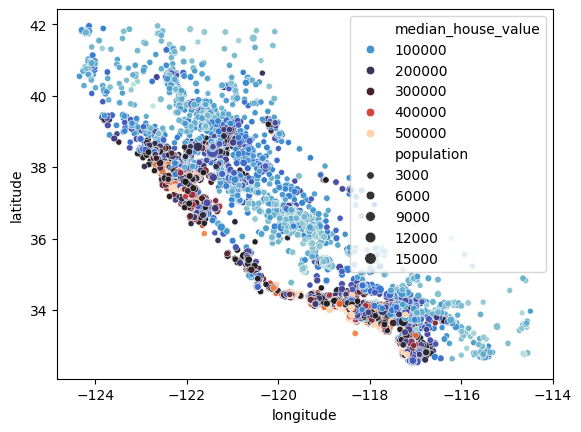

In [13]:
sns.scatterplot(x = housing.longitude, y = housing.latitude, size = housing.population, hue = housing.median_house_value, palette = 'icefire')

# Dealing with Numerical and Categorical Data

In [14]:
housing = strat_train_set.drop(columns= ['median_house_value'])
housing_labels = strat_train_set['median_house_value'].copy()

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

### Numerical Data

In [16]:
housing_num = housing.select_dtypes(include = [np.number])

In [17]:
imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

imputer.statistics_
housing_num.median()

X = imputer.transform(housing_num)

### Categorical Data

In [18]:
housing_cat = housing[['ocean_proximity']]

In [19]:
ord_encoder = OrdinalEncoder()
Y = ord_encoder.fit_transform(housing_cat)
ord_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [20]:
onehot_encoder = OneHotEncoder(sparse_output=False)
Z = onehot_encoder.fit_transform(housing_cat)

onehot_encoder.feature_names_in_
onehot_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

# Scaling and Normalization

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

### Features

In [22]:
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
A = minmax_scaler.fit_transform(housing_num)

In [23]:
std_scaler = StandardScaler()
B = pd.DataFrame(std_scaler.fit_transform(housing_num), columns= housing_num.columns)
B = std_scaler.inverse_transform(B)

In [24]:
age_similar_35 = rbf_kernel(housing[["housing_median_age"]], Y=[[35]], gamma = 0.1)

### Target

In [26]:
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(housing[['median_income']])

# Custom Transformer

In [27]:
from sklearn.preprocessing import FunctionTransformer # type: ignore

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

### Transfomers

In [28]:
log_transformer = FunctionTransformer(np.log, inverse_func= np.exp)
log_pop = log_transformer.transform(housing[['population']])
pop = log_transformer.inverse_transform(log_pop)

In [29]:
sf_transformer = FunctionTransformer(rbf_kernel, kw_args= dict(Y=[[37.7749, -122.41]], gamma = 0.1))
sf_simil = sf_transformer.transform(housing[['latitude','longitude']])

In [30]:
ratio_transformer = FunctionTransformer(lambda X: X[:,[0]] / X[:,[1]])

### Custom Class

In [31]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True):
        self.with_mean = with_mean
    def fit(self, X, y=None): # y is required even though we dont use it
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in = X.shape[1] # every estimator stores this in fit()
        return self # always return self
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in == X.shape[1]
        if self.with_mean: 
            X = X - self.mean_
        return X/self.scale_

In [32]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    def get_feature_names_out(self, names = None):
        return [f"Cluseter {i} similarity" for i in range(self.n_clusters)]

In [33]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude','longitude']], sample_weight = housing_labels)

<Axes: xlabel='longitude', ylabel='latitude'>

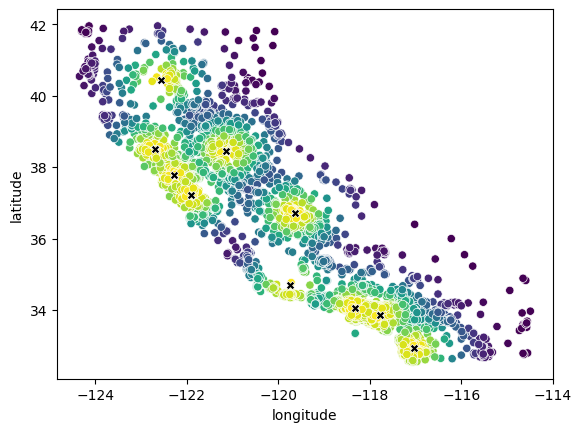

In [34]:
sns.scatterplot(x = housing['longitude'], y = housing['latitude'], c = similarities.max(axis = 1)) # pd.DataFrame(similarities).idxmax(axis = 1)
sns.scatterplot(y = cluster_simil.kmeans_.cluster_centers_[:,0], x = cluster_simil.kmeans_.cluster_centers_[:,1], marker='X', color = 'black')

# Pipeline

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

In [36]:
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [37]:
preprocessor = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)
preprocessor.transformers

[('pipeline-1',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('standardscaler', StandardScaler())]),
  <sklearn.compose._column_transformer.make_column_selector at 0x1b734677fb0>),
 ('pipeline-2',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                  ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))]),
  <sklearn.compose._column_transformer.make_column_selector at 0x1b734677ce0>)]

In [38]:
housing_prepared = preprocessor.fit_transform(housing)
pd.DataFrame(housing_prepared, columns = preprocessor.get_feature_names_out()).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   pipeline-1__longitude                   16512 non-null  float64
 1   pipeline-1__latitude                    16512 non-null  float64
 2   pipeline-1__housing_median_age          16512 non-null  float64
 3   pipeline-1__total_rooms                 16512 non-null  float64
 4   pipeline-1__total_bedrooms              16512 non-null  float64
 5   pipeline-1__population                  16512 non-null  float64
 6   pipeline-1__households                  16512 non-null  float64
 7   pipeline-1__median_income               16512 non-null  float64
 8   pipeline-2__ocean_proximity_<1H OCEAN   16512 non-null  float64
 9   pipeline-2__ocean_proximity_INLAND      16512 non-null  float64
 10  pipeline-2__ocean_proximity_ISLAND      16512 non-null  fl

# Complete Preprocessing

In [39]:
def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline= make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_similar = ClusterSimilarity(n_clusters=10, gamma = 1, random_state=42)

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population','households']),
    ('log', log_pipeline, ['total_bedrooms','total_rooms','population','households','median_income']),
    ('geo', cluster_similar, ['latitude','longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
],
remainder=num_pipeline)

In [40]:
housing_prepared = pd.DataFrame(preprocessing.fit_transform(housing), columns = preprocessing.get_feature_names_out())
housing_prepared


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluseter 0 similarity,geo__Cluseter 1 similarity,...,geo__Cluseter 6 similarity,geo__Cluseter 7 similarity,geo__Cluseter 8 similarity,geo__Cluseter 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,1.115293e-10,9.505920e-01,...,1.878046e-28,1.651285e-14,4.776856e-02,3.463930e-01,1.0,0.0,0.0,0.0,0.0,0.987087
16508,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,1.409886e-03,1.430917e-03,...,7.663746e-14,9.538119e-06,4.530237e-01,9.507766e-05,0.0,1.0,0.0,0.0,0.0,-0.443146
16509,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,8.098794e-20,3.501819e-02,...,1.715187e-42,5.158970e-25,5.966953e-06,1.346576e-01,0.0,0.0,0.0,0.0,1.0,-1.237721
16510,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,4.385614e-10,9.667073e-01,...,2.464809e-27,8.018690e-14,8.956217e-02,3.478114e-01,1.0,0.0,0.0,0.0,0.0,0.669257


# Training and Evaluating Model

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import root_mean_squared_error

In [42]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B736F6C080>)])),
                ('linearregression', LinearRegression())])

In [43]:
housing_predictions = lin_reg.predict(housing)
root_mean_squared_error(housing_labels, housing_predictions)

np.float64(68972.88910758484)

In [44]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B736F6C080>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [45]:
housing_predictions = tree_reg.predict(housing)
root_mean_squared_error(housing_labels, housing_predictions)

np.float64(0.0)

In [46]:
-cross_val_score(tree_reg, housing, housing_labels, scoring = 'neg_root_mean_squared_error', cv = 10).mean()

np.float64(67635.03066076766)

In [47]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
-cross_val_score(forest_reg, housing, housing_labels, scoring = 'neg_root_mean_squared_error', cv = 2)

array([48455.08225448, 49277.59829405])

# Finetuning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

### GridSearchCV

In [154]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])

param_grids = [
    {'preprocessing__geo__n_clusters': [8],
     'random_forest__max_features': [8]},
    {'preprocessing__geo__n_clusters':[15],
     'random_forest__max_features':[6]}
]


In [155]:
grid_search = GridSearchCV(full_pipeline, param_grids, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B736F6C080>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [8],
                          'random_forest__max_features': [8]},
                         {'preprocessing__geo__n_clusters': [15],
                          'random_forest__max_features': [6]}],
             scoring='neg_root_mean_squared_error')

In [158]:
print(grid_search.best_params_)
pd.DataFrame(grid_search.cv_results_)

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,16.228533,1.297637,0.259663,0.007944,8,8,"{'preprocessing__geo__n_clusters': 8, 'random_...",-46113.555510,-45750.013972,-46421.585934,-46095.051805,274.480133,2
1,12.258223,0.233927,0.259687,0.007265,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43520.694854,-43958.237963,-44759.841846,-44079.591555,513.105796,1


### RandomizedSearchCV

In [161]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low = 2, high = 20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter = 2, cv = 2, 
    scoring='neg_root_mean_squared_error', random_state=42
)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=2,
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B750D13E30>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B750D10D70>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [163]:
print(rnd_search.best_params_)

final_model = rnd_search.best_estimator_ # this includes preprocessing as well

feature_importances = final_model['random_forest'].feature_importances_.round(2)
features = pd.DataFrame(feature_importances, final_model['preprocessing'].get_feature_names_out())

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}


# Evaluating on Test Set

In [164]:
X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse

np.float64(41422.168800999665)

### Finding confidence interval

In [165]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))

array([39272.70918656, 43465.46272048])

# Exercises

### Exercise 1

In [166]:
from sklearn.svm import SVR

svm_reg = Pipeline([
    ('preprocessing',preprocessing),
    ('svr',SVR())
])

params = [
    {'svr__kernel':['linear'],
     'svr__C':[10,30,100,300]},
    {'svr__kernel':['rbf'],
     'svr__C':[10,30,100,300],
     'svr__gamma':[0.01,0.05]}
]

gd_search = GridSearchCV(svm_reg, param_grid=params, cv = 2, scoring = 'neg_root_mean_squared_error')
gd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B736F6C080>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10, 30, 100, 300],
                          'svr__kernel': ['linear']},
                         {'svr__C': [10, 30, 100, 300],
                          'svr__gamma': [0.01, 0.05], 'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [167]:
gd_search.best_params_

{'svr__C': 300, 'svr__kernel': 'linear'}

### Exercise 2

In [168]:
from scipy.stats import randint, uniform, geom, expon, loguniform

In [169]:
params = {
    'svr__kernel': ['linear','rbf'],
    'svr__C': loguniform(20, 20000),
    'svr__gamma': expon(scale = 1)
}

rnd = RandomizedSearchCV(svm_reg, param_distributions= params, n_iter = 10, cv =2, scoring = 'neg_root_mean_squared_error')

rnd.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001B736F6C080>)])),
                                             ('svr', SVR())]),
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B74E0B1010>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B750DE7080>,
                                        'svr__kernel': ['linear', 'rbf']},
                   scoring='neg_root_mean_squared_error')

In [142]:
rnd.best_estimator_[1]

SVR(C=np.float64(112.40210972508721), gamma=np.float64(1.0263433280175545),
    kernel='linear')

### Exercise 3

In [146]:
from sklearn.feature_selection import SelectFromModel

new_pipeline = Pipeline([
    ('preprocessing',preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42), threshold=0.005)), # min feature importance
    ('svr', rnd.best_estimator_[1])
])

-cross_val_score(new_pipeline,housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)

array([80045.42377933, 80607.64759358, 76560.20881773])

### Exercise 6

In [181]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True): # no *args or **kwargs
        self.with_mean = with_mean

    def fit(self, X, y=None): # y is required even though we dont use it
        X = check_array(X) # checks that X is array with finite float values
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator always stores this in fit()
        if hasattr(X, 'columns'):
            self.feature_names_in_ = np.array(X.columns, dtype=object)
        return self # always return self

    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing_)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError('Unknown number of features')
        if self.with_mean == True:
            X = X - self.mean_
        return X / self.std_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError('Unknown number of features')
        X = X * self.std_
        if self.with_mean == True:
            X = X + self.mean_
        return X
    
    def get_feature_nams_out(self, input_features = None):
        if input_features is None:
            return getattr(self, 'feature_names_in_', [f"x{i}" for i in range(self.n_features_in_)])
        else: 
            if (len(input_features)) != self.n_features_in_:
                raise ValueError('Invalid number of features')
            if hasattr(self, 'feature_names_in_') and not np.all(self.feature_names_in_ == input_features):
                raise ValueError('the features do not match')
            return input_features


In [182]:
from sklearn.utils.estimator_checks import check_estimator
 
check_estimator(StandardScalerClone())